cuda


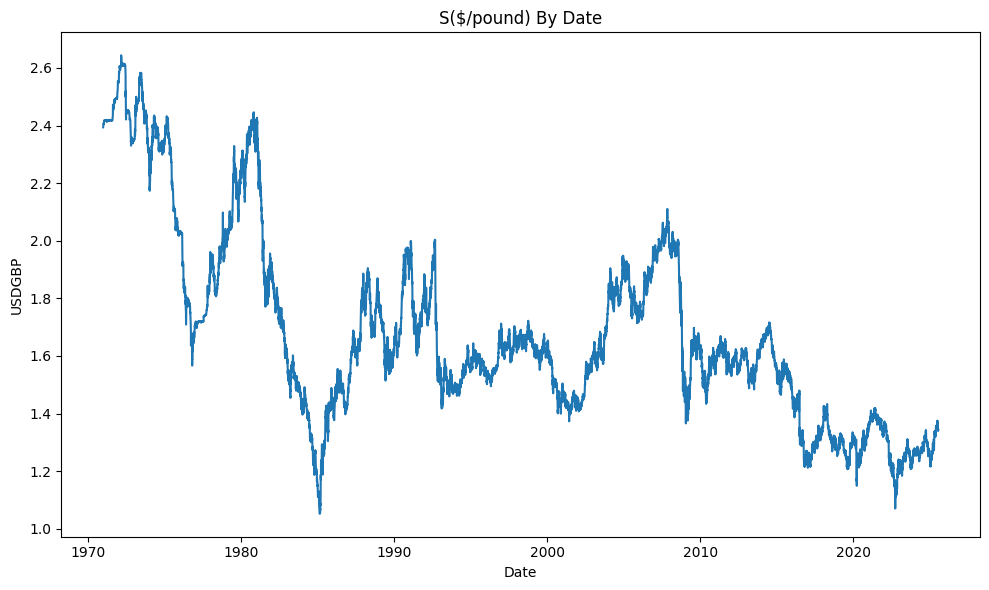

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler



device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)

"""The USD/GBP Spot rate"""

usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDGBP',data=df)
plt.title("S($/pound) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()






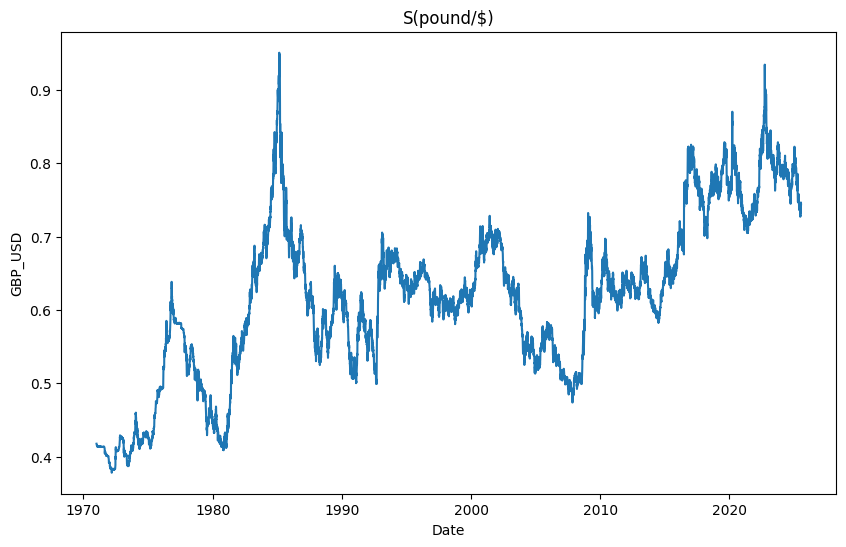

In [2]:
""" Example of S(pound/USD)"""

df1 = df.copy()
df1['GBP_USD'] = 1 / df['USDGBP']

plt.figure(figsize=(10,6))
sns.lineplot(x=df1['Date'],y=df1['GBP_USD'])
plt.title("S(pound/$)")
plt.savefig("images/sportrate_GBPUSD")
plt.show()




In [3]:



GBP_USD = 1  / df['USDGBP']

USD_GBP = 1 / GBP_USD

A = np.array([[USD_GBP,GBP_USD],[GBP_USD,USD_GBP]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')



1:1 Parity of of Exchange Rates: [[[2.3938     0.41774584]
  [0.41774584 2.3938    ]]

 [[2.3949     0.41755397]
  [0.41755397 2.3949    ]]

 [[2.3967     0.41724037]
  [0.41724037 2.3967    ]]

 ...

 [[1.3426     0.74482348]
  [0.74482348 1.3426    ]]

 [[1.3413     0.74554537]
  [0.74554537 1.3413    ]]

 [[1.3439     0.74410298]
  [0.74410298 1.3439    ]]]


In [4]:
df1 = df.copy()


df1.dropna(inplace=True)

df_train = df1.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length - 1):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 4

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        c0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out





In [5]:




lstm_model = LSTM(input_size=1,hidden_size=128,num_layers=1,output_size=1)
epochs = 500
learning_rate = 0.001



lstm_optimizer = torch.optim.Adam(params=lstm_model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

In [6]:


for epoch in range(epochs):
    y_pred = lstm_model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    lstm_optimizer.zero_grad()
    loss.backward()
    lstm_optimizer.step()
    if epoch % 1 != 0:
        continue
    lstm_model.eval()
    with torch.no_grad():
        y_pred = lstm_model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  lstm_model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')
        




C:\Users\katsa\AppData\Local\Temp\ipykernel_12860\1282510991.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_12860\1282510991.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4928; Test RSME: 0.1864
Epoch: 1; train_RSEM: 0.4732; Test RSME: 0.1675
Epoch: 2; train_RSEM: 0.4538; Test RSME: 0.1487
Epoch: 3; train_RSEM: 0.4345; Test RSME: 0.1301
Epoch: 4; train_RSEM: 0.4153; Test RSME: 0.1116
Epoch: 5; train_RSEM: 0.396; Test RSME: 0.09321
Epoch: 6; train_RSEM: 0.3764; Test RSME: 0.07521
Epoch: 7; train_RSEM: 0.3566; Test RSME: 0.05822
Epoch: 8; train_RSEM: 0.3365; Test RSME: 0.04411
Epoch: 9; train_RSEM: 0.3158; Test RSME: 0.03754
Epoch: 10; train_RSEM: 0.2948; Test RSME: 0.04358
Epoch: 11; train_RSEM: 0.2733; Test RSME: 0.05974
Epoch: 12; train_RSEM: 0.2517; Test RSME: 0.08129
Epoch: 13; train_RSEM: 0.2303; Test RSME: 0.106
Epoch: 14; train_RSEM: 0.2098; Test RSME: 0.1331
Epoch: 15; train_RSEM: 0.1914; Test RSME: 0.1621
Epoch: 16; train_RSEM: 0.1769; Test RSME: 0.1927
Epoch: 17; train_RSEM: 0.1683; Test RSME: 0.2241
Epoch: 18; train_RSEM: 0.167; Test RSME: 0.2554
Epoch: 19; train_RSEM: 0.1727; Test RSME: 0.2846
Epoch: 20; train_RSEM: 0.

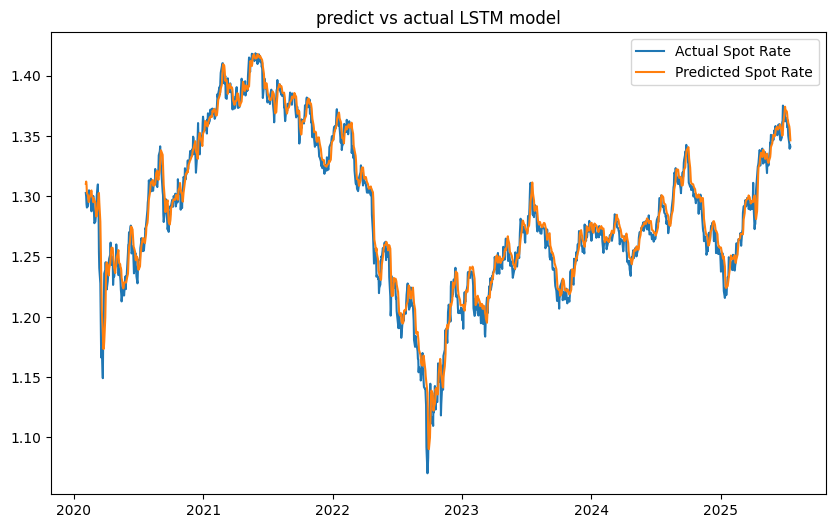

In [9]:

with torch.no_grad():
    pred = lstm_model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df1.iloc[train_size + seq_length: -1]['Date']


lstm_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(lstm_comparison_df['Date'],lstm_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(lstm_comparison_df['Date'],lstm_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predict vs actual LSTM model")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_lstm.png")
plt.show()


In [10]:
print(np.round(lstm_comparison_df,4).head(20))
print(np.round(lstm_comparison_df,4).tail(20))


            Date  Actual Spot Rate  Predicted Spot Rate
12314 2020-02-04            1.3029               1.3105
12315 2020-02-05            1.3000               1.3124
12316 2020-02-06            1.2935               1.3100
12317 2020-02-07            1.2908               1.3028
12318 2020-02-10            1.2919               1.3010
12319 2020-02-11            1.2945               1.2977
12320 2020-02-12            1.2978               1.2954
12321 2020-02-13            1.3051               1.2958
12322 2020-02-14            1.3039               1.2986
12323 2020-02-18            1.3017               1.3019
12324 2020-02-19            1.2934               1.3045
12325 2020-02-20            1.2877               1.3050
12326 2020-02-21            1.2966               1.3014
12327 2020-02-24            1.2923               1.2982
12328 2020-02-25            1.3004               1.2952
12329 2020-02-26            1.2921               1.2960
12330 2020-02-27            1.2876              